In [1]:
PRFX_ESMB = 'MelInfEsmb0815C2'

In [2]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc
import matplotlib.pyplot as plt

class Param: pass

p_esmb = f'../output/{PRFX_ESMB}'; Path(p_esmb).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

# starting weights

In [3]:
prfx2wgt0 = {
    'MelInf0726B2tta16': 0.15,
    'MelInf0805A1tta16': 0.15,
    'MelInf0728A1tta16': 0.25,
    'MelInf0728B1tta16': 0.15,
    'MelInf0805C1tta16': 0.15,
    'MelInf0727A1tta16': 0.2,
    'MelInf0805D1tta16': 0.2,
    'MelInf0727B1tta16': 0.2,
    'MelInf0805E1tta16': 0.2,
    'MelInf0726G2tta16': 0.15,
    'MelInf0726G4tta16': 0.15,
    'MelInf0726H2tta16': 1,
    'MelInf0729H1tta16': 1,
    'MelInf0729E1tta16': 1,
    'MelInf0729D1tta16': 0.3,
    'MelInf0806C1tta16': 1.0,
    'MelInf0729F1tta16': 0.5,
    'MelInf0806D1tta16': 0.5,
    'MelInf0729C1tta16': 0.5,
    'MelInf0729C1tta16epc456': 0.5,
    'Mel0806E1tta16epc345': 1.5,
    'MelInf0808A1tta16': 0.5,
    'MelInf0729G3tta16epc567': 1,
    'MelInf0801A1tta16': 1,
    'MelInf0801B1tta16epc567':1,
    'MelInf0801C1tta16':1,
    'MelInf0801D2tta16':0.3,
    'MelInf0801E1tta16':0.3,
    'MelInf0801F1tta16epc489':1.5,
}

In [4]:
prfx2oofs = {}
for prfx in prfx2wgt0.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)

    oofs = np.array(oofs)
    prfx2oofs[prfx] = oofs
    
    scr = roc_auc(ys, oofs)
    print(param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}', prfx2wgt0[prfx], prfx)

efficientnet-b0 224 0.9279 0.8960 0.15 MelInf0726B2tta16
efficientnet-b0 224 0.9236 0.8962 0.15 MelInf0805A1tta16
efficientnet-b1 224 0.9301 0.9082 0.25 MelInf0728A1tta16
efficientnet-b2 224 0.9298 0.9062 0.15 MelInf0728B1tta16
efficientnet-b2 224 0.9287 0.9053 0.15 MelInf0805C1tta16
efficientnet-b3 224 0.9294 0.9063 0.2 MelInf0727A1tta16
efficientnet-b3 224 0.9292 0.9064 0.2 MelInf0805D1tta16
efficientnet-b4 224 0.9318 0.9094 0.2 MelInf0727B1tta16
efficientnet-b4 224 0.9312 0.9103 0.2 MelInf0805E1tta16
efficientnet-b5 224 0.9288 0.9113 0.15 MelInf0726G2tta16
efficientnet-b5 224 0.9277 0.8979 0.15 MelInf0726G4tta16
efficientnet-b6 224 0.9317 0.9139 1 MelInf0726H2tta16
efficientnet-b0 384 0.9336 0.9063 1 MelInf0729H1tta16
efficientnet-b1 384 0.9340 0.9196 1 MelInf0729E1tta16
efficientnet-b2 384 0.9347 0.9205 0.3 MelInf0729D1tta16
efficientnet-b2 384 0.9375 0.9302 1.0 MelInf0806C1tta16
efficientnet-b3 384 0.9330 0.9169 0.5 MelInf0729F1tta16
efficientnet-b3 384 0.9353 0.9219 0.5 MelInf080

In [5]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt0.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += wgt*prfx2oofs[prfx]
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(PRFX_ESMB, f'{scr:.4f}', f'{scr20:.4f}')

MelInfEsmb0815C2 0.9429 0.9281


# optimize

In [6]:
prfxes, wgts0 = list(zip(*prfx2wgt0.items()))

- https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa
- http://localhost:8080/notebooks/git/google-quest-challenge/working/QstPstp0208_4.ipynb

In [7]:
oofss = []
for prfx in prfxes:
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)
    print(vls[:15])
    oofss.append(oofs)
oofss = np.array(oofss)

[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21, 29, 32, 33, 43, 47, 53]
[0, 1, 4, 6, 10, 15, 17, 19, 21

In [8]:
oofss.shape

(29, 58032)

In [9]:
import scipy as sp

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _minus_scr(self, coef):
        prd = np.average(oofss, axis=0, weights=coef)
        scr = roc_auc(ys, prd)
        return -scr
    
    def fit(self):
        initial_coef = wgts0
        self.coef_ = sp.optimize.minimize(self._minus_scr, initial_coef, method='Nelder-Mead')
    
    def get_coef(self):
        return self.coef_['x']

In [10]:
%%time
optR = OptimizedRounder()
optR.fit()
coef = optR.get_coef()


CPU times: user 2min 51s, sys: 157 ms, total: 2min 51s
Wall time: 2min 53s


In [11]:
coef

array([ 41.27185888,   5.12519794, -42.7370966 ,  10.12139774,
        -6.13003714, -23.88242032, -59.81617658,   5.80192998,
        -1.43943641,  -5.77893379,  -6.16850648, 180.82143232,
       -16.73590179, -12.1643857 , -17.94853396, 107.79550153,
         5.31851335, -29.03681374,  51.87712034, -30.34458973,
       218.36897022, -65.50486321, -20.65808317,  75.61411792,
       134.04428374,  27.17309749, -82.84454033, -51.10187709,
       274.21928051])

In [12]:
prd=np.average(oofss, axis=0, weights=coef)
roc_auc(ys, prd)

0.9448725374406388

In [13]:
prfx2wgt = dict(zip(prfxes, coef))

In [14]:
prfx2oofs = {}
for prfx in prfx2wgt.keys():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    vls=[]
    oofs=[]
    for fld in range(4):
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{prfx}_fld_{fld}.p', 'rb'))
        _,vl= res['fld2trvl'][fld]
        vls += list(vl)
        ep2oof = np.concatenate(ep2oof, 1)
        oof = ep2oof.mean(1)
        oofs += list(oof)

    ys = dftrn.target.iloc[vls]
    sortedzip = sorted(zip(vls, oofs, ys))
    _, oofs, ys = list(zip(*sortedzip))
    assert np.all(dftrn.target==ys)

    oofs = np.array(oofs)
    prfx2oofs[prfx] = oofs
    
    scr = roc_auc(ys, oofs)
    print(param.ARCH, param.SZ, f'{scr:.4f}', end=' ')
    
    idx20 = np.where(dftrn.source==20)[0]
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs[idx20])
    print(f'{scr20:.4f}', prfx2wgt[prfx], prfx)

efficientnet-b0 224 0.9279 0.8960 41.271858882738414 MelInf0726B2tta16
efficientnet-b0 224 0.9236 0.8962 5.125197943165626 MelInf0805A1tta16
efficientnet-b1 224 0.9301 0.9082 -42.73709660254936 MelInf0728A1tta16
efficientnet-b2 224 0.9298 0.9062 10.121397741206607 MelInf0728B1tta16
efficientnet-b2 224 0.9287 0.9053 -6.1300371439331 MelInf0805C1tta16
efficientnet-b3 224 0.9294 0.9063 -23.882420318588434 MelInf0727A1tta16
efficientnet-b3 224 0.9292 0.9064 -59.81617658116517 MelInf0805D1tta16
efficientnet-b4 224 0.9318 0.9094 5.801929980342871 MelInf0727B1tta16
efficientnet-b4 224 0.9312 0.9103 -1.4394364066258551 MelInf0805E1tta16
efficientnet-b5 224 0.9288 0.9113 -5.778933790325924 MelInf0726G2tta16
efficientnet-b5 224 0.9277 0.8979 -6.168506481417703 MelInf0726G4tta16
efficientnet-b6 224 0.9317 0.9139 180.82143231822027 MelInf0726H2tta16
efficientnet-b0 384 0.9336 0.9063 -16.735901789793182 MelInf0729H1tta16
efficientnet-b1 384 0.9340 0.9196 -12.164385699327994 MelInf0729E1tta16
effici

In [15]:
oofs_esmb= np.zeros(len(dftrn))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    p_prp = f'../output/{param.PRFX_PREP}'
    dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 

    oofs_esmb += wgt*prfx2oofs[prfx]
    scr = roc_auc(ys, oofs_esmb)
    scr20 = roc_auc(dftrn.target.iloc[idx20], oofs_esmb[idx20])
print(PRFX_ESMB, f'{scr:.4f}', f'{scr20:.4f}')

MelInfEsmb0815C2 0.9449 0.9321


In [16]:
dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv') 


wgt_ttl=0
sub_esmb=np.zeros(len(dfsub))
for prfx,wgt in prfx2wgt.items():
    p_out = f'../output/{prfx}'
    res = pickle.load(open(f'{p_out}/results_{prfx}.p', 'rb'))
    param = res['param']
    dfsubi = pd.read_csv(f'{p_out}/submission_{prfx}_avglast{param.LASTM}.csv')
    wgt_ttl+=wgt
    subi = dfsubi.target
    print(prfx, subi.mean())
#     plt.hist(subi, bins=50);
#     plt.show()
    sub_esmb += wgt*subi
sub_esmb/=wgt_ttl

MelInf0726B2tta16 0.17577293900882407
MelInf0805A1tta16 0.1852360767356046
MelInf0728A1tta16 0.1697970152984186
MelInf0728B1tta16 0.15783098760570596
MelInf0805C1tta16 0.18550869943493037
MelInf0727A1tta16 0.15930823437581493
MelInf0805D1tta16 0.17837462669376472
MelInf0727B1tta16 0.15253438272176548
MelInf0805E1tta16 0.17570575343026482
MelInf0726G2tta16 0.15595904496625135
MelInf0726G4tta16 0.195412380182344
MelInf0726H2tta16 0.15230585584603645
MelInf0729H1tta16 0.15282431964950818
MelInf0729E1tta16 0.14824956054377292
MelInf0729D1tta16 0.1499509768921909
MelInf0806C1tta16 0.1632805076088609
MelInf0729F1tta16 0.1487084176636413
MelInf0806D1tta16 0.17213049339909336
MelInf0729C1tta16 0.1371323752740608
MelInf0729C1tta16epc456 0.1582704462621681
Mel0806E1tta16epc345 0.1657605117769836
MelInf0808A1tta16 0.1786412484494178
MelInf0729G3tta16epc567 0.18763088324121233
MelInf0801A1tta16 0.16702342384519106
MelInf0801B1tta16epc567 0.17403774669167732
MelInf0801C1tta16 0.1757464726584606
Mel

0.1534032008704594


,image_name,target
0,ISIC_0052060,0.063037
1,ISIC_0052349,0.042306
2,ISIC_0058510,0.074914


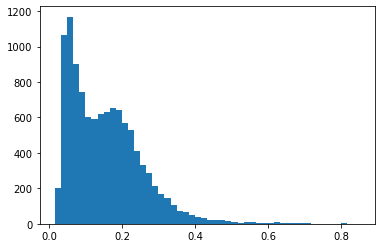

In [17]:
print(sub_esmb.mean())
dfsub.target = sub_esmb

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [18]:
dfsub.to_csv(f'{p_esmb}/submission_{PRFX_ESMB}.csv', index=False)